## Investing factors influencing route choice from Connected Car Data

                                    Generating Key Statistical Measures

In [1]:
#Scikit Mobility Library
import skmob
from skmob import preprocessing
from skmob.preprocessing import detection, clustering
from skmob.preprocessing import compression

#Datashader Library
#import datashader as ds, pandas as pd, colorcet as cc
# from datashader import transfer_functions as tf
# from datashader.colors import Hot
# from datashader.utils import export_image

#Dask & Flask_sqlalchemy libraries
# import dask
# import sqlalchemy


#Other ancillary Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import seaborn; seaborn.set()
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.style.use('ggplot')
import geopandas as gpd
import pyarrow
import pyodbc
import webbrowser
import glob
import os

import warnings
warnings.filterwarnings('ignore')

In [3]:
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [4]:
%watermark

Last updated: 2023-03-22T13:18:37.328031+00:00

Python implementation: CPython
Python version       : 3.10.8
IPython version      : 8.7.0

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 106 Stepping 6, GenuineIntel
CPU cores   : 8
Architecture: 64bit



In [5]:
%watermark --iversions

geopandas : 0.12.2
numpy     : 1.23.5
skmob     : 1.3.1
seaborn   : 0.12.1
matplotlib: 3.6.2
pyarrow   : 10.0.1
pyodbc    : 4.0.35
pandas    : 1.5.2



---

### Set up Connection to database from notebook

### Connect to Database using Dask


First creat client which allows user to moniter process of task

**Retrive** Data using Dask 

In [150]:
# from dask.distributed import Client

# client = Client(n_workers=4, threads_per_worker=4)

# client

In [125]:
# import dask.dataframe as dd

In [131]:
# ddf = dd.read_sql_table(
#    table_name ="trajectories_processed", 
#    con = "mssql+pyodbc:///?odbc_connect=DRIVER={ODBC Driver 17 for SQL Server}; SERVER=tcp:az-lrdp-p0349v01-db.database.windows.net; DATABASE=VRE-p0349v01-db; UID=medekar@leeds.ac.uk; AUTHENTICATION=ActiveDirectoryInteractive", 
#    index_col="journeyKey"
# )

### Visualise Entire Dataset

Using Datashader 

In [132]:
# %%time
# S = dd.read_parquet("AllTrip_trajectory.parquet", engine='pyarrow')

In [64]:
# agg = ds.Canvas(plot_width=500, plot_height=900).points(S4,'longitude', 'latitude')

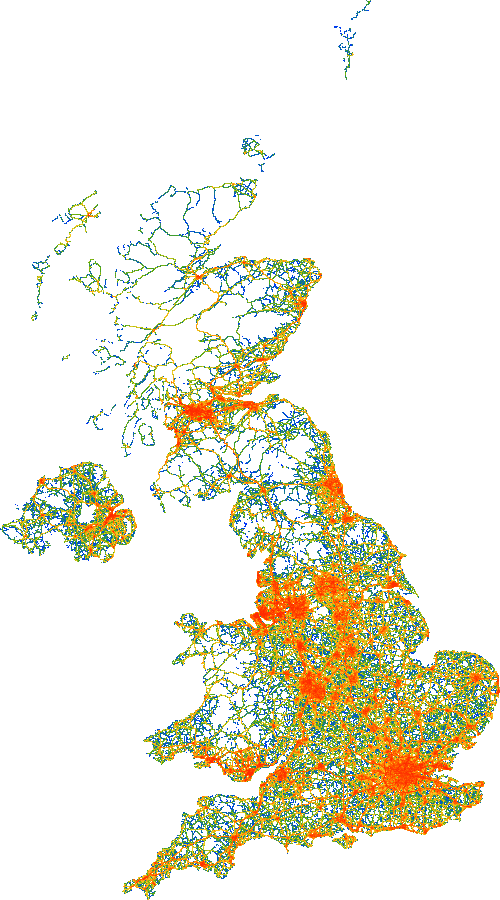

In [65]:
# ds.tf.set_background(ds.tf.shade(agg, cmap=cc.rainbow), "white" )

### Connect Notebook to SQL


**Retrive** Data in batches from SQL, Connection to SQL

In [2]:
con = "mssql+pyodbc:///?odbc_connect=DRIVER={ODBC Driver 17 for SQL Server}; SERVER=tcp:az-lrdp-p0349v01-db.database.windows.net; DATABASE=VRE-p0349v01-db; UID=medekar@leeds.ac.uk; AUTHENTICATION=ActiveDirectoryInteractive" 

###### Read in data in batches (smaller sizes) in order to work with pandas and scikit mobility

In [2]:
# batch_size = 90398
# batch_start = 1740413
# batch_end = batch_start + batch_size
# while batch_end<= 1830811:
#     df = pd.read_sql(f"SELECT * FROM trajectories_processed where journeyKey between {batch_start} and {batch_end}", con)
#     df.to_parquet(f"batch_{batch_start}_{batch_end}.parquet", engine="pyarrow", compression="snappy")
    
#     batch_start = batch_end + 1
#     batch_end = batch_start + batch_size

### Read in batched file for analysis

In [2]:
%%time
S2 = pd.read_parquet("batch_1740413_1830811.parquet", engine='pyarrow')

CPU times: total: 9.11 s
Wall time: 7.54 s


#### Explore & Clean Data

In [3]:
S2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22776333 entries, 0 to 22776332
Data columns (total 9 columns):
 #   Column            Dtype         
---  ------            -----         
 0   dataPointKey      int64         
 1   journeyKey        int64         
 2   capturedDatetime  datetime64[ns]
 3   latitude          float64       
 4   longitude         float64       
 5   geohash           object        
 6   countryCode       object        
 7   speed             float64       
 8   heading           float64       
dtypes: datetime64[ns](1), float64(4), int64(2), object(2)
memory usage: 1.5+ GB


###### Grouping and sorting data

In [4]:
%%time
S2.groupby(by = ['journeyKey','capturedDatetime'])

CPU times: total: 0 ns
Wall time: 1 ms


In [1]:
S3= S2.sort_values(by = ['journeyKey','capturedDatetime'])
S3.head()

### Create Scikit mobility dataframe, change headings, create 'uid' in order to use scikit mobility functions

In pandas I used .ngroup() to create UID's in dask .cumcount() does this.

In [6]:
S3.drop(['countryCode'],axis=1, inplace=True)

In [7]:
%%time
S3['uid'] = S3.groupby(by='journeyKey').ngroup()

CPU times: total: 1.03 s
Wall time: 1.04 s


Rename Columns allowing Scikit-Mobility dataframe to work the way it should

In [8]:
%%time
S4 = S3.rename(columns={'journeyKey':'tid', 'capturedDatetime':'datetime','latitude':'lat','longitude':'lng','geohash':'geohash','speed':'speed','heading':'vehicledirection','uid':'uid'})

CPU times: total: 766 ms
Wall time: 776 ms


In [2]:
S4.head()

# Descriptive Statistics

Here I seek to understand how human mobility. How long are their movements, how much time is spent in travel, where and how long are their stops  etc partly based on literature below

<font color='Purple'>

- Human mobility is charaterised by a high degree of predicatability (Eagle and Pentland 2009; Song et al. 2010)

- A high tendancy to spend lots of time in a few locations (Song et al. 2010)

- A propensity to visit specific locations at specific time (Jiang et al. 2012; Rinzivillo et al. 2014)</font>

                                    GENERATING KEY STATISTICAL MEASURES

## 1. Distance Traveled

- Always convert to Skmob dataframe before using scikit mobility functions
- Straight Line distance (**Kilometers**) 

#### What Scikit-Mobility Function is doing - **It summing the geographic distance between consecutive points** 

Result - **<font color="Green">Total Distance travel on a journey</font>**


In [10]:
from skmob.measures.individual import distance_straight_line

In [11]:
%%time
SL = skmob.TrajDataFrame(S4, latitude='lat', longitude='lng', datetime='datetime', user_id='uid').sort_values(by=['uid','datetime'])

CPU times: total: 18.3 s
Wall time: 18.3 s


In [12]:
%%time
M = distance_straight_line(SL)

100%|███████████████████████████████████████████████████████████████████████| 90399/90399 [03:34<00:00, 421.87it/s]

CPU times: total: 3min 34s
Wall time: 3min 34s


Distance Travelled - Wall time: 5min 48s

In [3]:
M.head()

In [14]:
S5 = S4.merge(M, on='uid', how='left')

In [15]:
S6 = S5[['tid', 'distance_straight_line']].drop_duplicates()

In [183]:
S6.head(2)

#### Identifying Start Times

In [17]:
%%time
Fis = S4.groupby('tid')['datetime'].first()

CPU times: total: 406 ms
Wall time: 416 ms


In [18]:
%%time
starTime = Fis.reset_index()

CPU times: total: 0 ns
Wall time: 999 µs


In [4]:
starTime

In [20]:
batch1 = S6.merge(starTime, on='tid', how='left')

#### Identifying Origins

In [21]:
orig  = S4.groupby('tid')['lat','lng'].first()

In [22]:
orig['origin'] = orig.apply(lambda row: [row['lat'], row['lng']], axis= 1)

#### Identifying Destinations

In [23]:
dest  = S4.groupby('tid')['lat','lng'].last()

In [24]:
dest['dest'] = dest.apply(lambda row: [row['lat'], row['lng']], axis= 1)

In [25]:
batch2 = batch1.merge(orig, on='tid', how='left')

In [27]:
b = batch2.merge(dest, on='tid', how='left')

In [29]:
b.drop(['lat_x','lng_x','lat_y','lng_y'], axis=1, inplace=True)

## 2. Stop detection

- Detect stops 

In [5]:
%%time
Ma = detection.stay_locations(SL, stop_radius_factor=0.2, minutes_for_a_stop=1.0, leaving_time = (True), spatial_radius_km=0.2)
Ma.groupby('tid')
Ma.head(3)

CPU times: total: 0 ns
Wall time: 0 ns


Stop Detection - Wall time: 19min 15s

#### Calculate Stopping Time

In minutes -- .dt. is a datetime function

In [6]:
%%time
Ma['StopTime']  = (Ma['leaving_datetime'] - Ma['datetime']).dt.total_seconds()/60
Ma.head(3)

CPU times: total: 0 ns
Wall time: 0 ns


In [33]:
stopT = Ma.groupby('tid')['StopTime'].sum()

In [35]:
c = b.merge(stopT, on='tid', how='left')

## 3. Travel Time Duration


Time Intervals calculation in minutes

In [37]:
%%time
S4['Traveltime'] = (S4['datetime'] - S4.groupby('tid')['datetime'].shift()).dt.total_seconds()/60
S4.fillna(0, inplace=True)

CPU times: total: 5.38 s
Wall time: 5.38 s


Travel Time - Wall time: 8.03 s

In [38]:
T = S4.groupby('tid')['Traveltime'].sum()

In [40]:
d = c.merge(T, on='tid', how='left')

## 4. Number of Turns


1. For each tid, calculate the number of turns by comparing the bearing(direction) at each GPS recording to the heading of the previous GPS recording. if the difference is greater that the assinged threshold (e.g. 50 degrees) it is considered a turn. 


2. Use the .apply() method to apply the function to each group that calculates number of turns. 

Sum of turns between two points surpassing 50 degrees in either direction, *with more turns indicative of higher perceived cognitive distance.* <font color = green> (Sadalla, E.K. & Magel, S.G. 1980) The perception of traversed distance </font>

*SL = Scikit-Mobility dataframe created above.*

In [42]:
def calc_num_turns(SL):
    num_turns = 0
    prev_bearing = SL["vehicledirection"].iloc[0]
    for i in range(1, len(SL)):
        curr_bearing = SL["vehicledirection"].iloc[i]
        if abs(curr_bearing - prev_bearing) > 50:
            num_turns += 1
        prev_bearing = curr_bearing
    return num_turns

Group the dataframe by trip_id and apply the calc_num_turns function to each group

In [43]:
%%time
df_turns = SL.groupby('tid').apply(calc_num_turns)
df_turns.head()

CPU times: total: 5min 3s
Wall time: 5min 4s


tid
1740413     2
1740414    11
1740415    16
1740416    43
1740417    25
dtype: int64

Number of Turns - Wall time: 7min 24s

In [44]:
df_turns = df_turns.reset_index()
df_turns = df_turns.rename(columns={ 0:'num_of_turns'})
df_turns.head()

,tid,num_of_turns
0,1740413,2
1,1740414,11
2,1740415,16
3,1740416,43
4,1740417,25


In [45]:
e = d.merge(df_turns, on='tid', how='left')

## 5. Cumulative Angular Deviation

- calculate the change in bearing at each point in the series (Subtract bearing a one point from the next), similar method to finding time traveled between points.

- convert these changes to within a range of -180 to 180 degrees standardizing changes. If bearing recording is greater than 180 it means the car has turned in the opposite direction.


I begun to notice that there were 'Nan' values in the dataset and thought it was affecting the angular deviation calculation so I wanted to find the first position of all tid's and begin the subtraction process from there 


- add all absolute anglular deviations to arrive at cumulative angular deviation

In [7]:
%%time
SL["bearing_change"] = SL["vehicledirection"] - SL.groupby("tid")["vehicledirection"].shift()
SL.head()

CPU times: total: 0 ns
Wall time: 0 ns


*Maybe I shouldn't have used a forward fill and just set the fill value to zero ? Not sure*

In [48]:
SL["bearing_change"].fillna(method="ffill", inplace=True)

In [49]:
adjusted_deviation = lambda x: x+360 if x < -180 else x-360 if x > 180 else x

In [50]:
%%time
SL["bearing_change"] = SL["bearing_change"].apply(adjusted_deviation)

CPU times: total: 5.61 s
Wall time: 5.62 s


Cumulative Angular Deviation - Wall time: 8 s

To calculate Cumulative Angular deviation, make values absolute *(this finds the change in bearing irrespective of the direction of change)* ands add them. 

In [51]:
SL["abs_bearing_change"] = abs(SL["bearing_change"])

In [52]:
angular_dev = SL.groupby("tid")["abs_bearing_change"].sum()

In [53]:
cum_angular_dev = angular_dev.reset_index()

In [55]:
g= e.merge(cum_angular_dev, on='tid', how='left')

In [57]:
nextone = g[['tid','origin','dest','distance_straight_line','datetime','Traveltime','StopTime','num_of_turns','abs_bearing_change']]

In [60]:
nextone.to_parquet("thirteenthbatch.parquet")

#### Combine all results into single dataframe of individual journeys,<font color = 'red'> then move on to step 6 & 7 </font>

In [ ]:
batch1 = pd.read_parquet('Firstbatch.parquet')
batch1

In [ ]:
batch2 = pd.read_parquet('secondbatch.parquet')
batch2

In [ ]:
batch3 = pd.read_parquet('thirdbatch.parquet')
batch3

In [ ]:
batch4 = pd.read_parquet('fourthbatch.parquet')
batch4

In [64]:
batch5 = pd.read_parquet("fifthbatch.parquet")
batch5

In [66]:
batch6 = pd.read_parquet("sixthbatch.parquet")
batch6

In [60]:
batch7 = pd.read_parquet("seventhbatch.parquet")
#batch7

In [63]:
batch8 = pd.read_parquet("eightbatch.parquet")
#batch8

In [61]:
batch9 = pd.read_parquet("ninthbatch.parquet")
#batch9

In [60]:
batch10 = pd.read_parquet("tenthbatch.parquet")
#batch10

In [60]:
batch11 = pd.read_parquet("eleventhbatch.parquet")
batch11

In [61]:
batch12 = pd.read_parquet("twelfthbatch.parquet")
batch12

In [158]:
batch13 = pd.read_parquet("thirteenthbatch.parquet")
batch13

## Summary Statistics Dataframe

In [66]:
ukmain1.shape

(1830811, 9)

In [147]:
ukmain1.to_parquet("Ukmaindata1.parquet")

## 6. Calculating straight line distance (origin and destination) through dataframe


1. Function to obtain straight line distance of origin to destination using <font color='green'>osmnx distance.great_circle_vec function</font>

In [73]:
%%time

def calculate_distance(ukmain1):
    distance_list = []
    for i, row in ukmain1.iterrows():
        # loop through dataframe
        lat1 = row['origin'][0] 
        lng1 = row['origin'][1]
        lat2 = row['dest'][0] 
        lng2 = row['dest'][1]

        #find Straight Line Distance

        distance_list.append(ox.distance.great_circle_vec(lat1,lng1,lat2,lng2,earth_radius=6371009))       
    return distance_list

CPU times: total: 0 ns
Wall time: 0 ns


In [74]:
%%time
ukmain1['shortestPath_dist'] = calculate_distance(ukmain1)

CPU times: total: 2min 24s
Wall time: 2min 24s


In [75]:
kilometer = lambda x: x/1000

In [76]:
%%time
ukmain1['shortestPath_dist'] = ukmain1['shortestPath_dist'].apply(kilometer)

CPU times: total: 375 ms
Wall time: 381 ms


## 7. Calculating Sinuosity through dataframe

In [4]:
%%time 

def sinuosity(ukmain1):
    sinu_list = []
    for i, row in ukmain1.iterrows():
        if row['shortestPath_dist'] < 0.1:
            sinu = 0
        else:
            sinu = row['distance_straight_line']/row['shortestPath_dist']
    
    #find sinuosity  
        sinu_list.append(sinu)
    return sinu_list

CPU times: total: 0 ns
Wall time: 0 ns


In [5]:
%%time
ukmain1['sinuosity'] = sinuosity(ukmain1)

CPU times: total: 1min 40s
Wall time: 1min 40s


In [9]:
ukmain1['StopTime'].fillna(0, inplace=True)

In [7]:
uk1.to_parquet(r"N:\Code Routing Behaviour\Ukmaindata1.parquet")

                                                     SPLIT - New Notebook